In [3]:
'''Useful libraries'''

import pandas as pd
from pandas.io.json import json_normalize
import json
import folium
import numpy as np
import matplotlib.pyplot as plt

## Question 1.
Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

# Answer 1

# Part I: choosing and processing data

Here, we understand that the total enemployment rate of Europe is desired and should comprise the data for Switzerland.
The majority of the provided data do not comprise Switzerland and contain only a subset of the European countries. However, we found the following data:
http://ec.europa.eu/eurostat/tgm/refreshTableAction.do?tab=table&plugin=1&pcode=tepsr_wc170&language=en

This data contains the unemployment rate by age, but there is one cathegory 15-75 years and all ISCED 2011 levels, which means all education levels, that we consider as a total unemployment rate. Moreover, this data comprises Switzerland therefore it is the best candidate we found.

Then, we have to:
<br>
1- extract data at a recent date, for the desired category (15-75, all ISCED)
<br>
2- clean for strings ('b', 'u' and 'r' are present in the data series) to convert values to float
<br>
3- standardize country names to match the topojson names

In [4]:
'''Import Data'''

raw_data = pd.DataFrame()
raw_data = raw_data.from_csv("lfsa_urgaed_1.tsv", sep="\t")
raw_data.isnull().values.any()

False

In [5]:
'''Extracting data of interest'''

# here we create a transitory data frame to exclude non-country categories (e.g European area)
# and keep only the most recent year data

cols = list(raw_data.columns)
last_date = cols[-1] # data is build with increasing year so we keep the last

transitory = pd.DataFrame(raw_data[last_date].loc[raw_data.index.str.contains('Euro area|European Union')==False])

# we select the desired category
transitory = transitory.loc[transitory.index.str.contains('Total,From 15 to 74 years,All ISCED 2011 levels')]

# and exclude the countries for which value is unknown
transitory = transitory.loc[transitory[last_date].str.contains(':')==False]

In [6]:
'''Cleaning data values'''

# create a list to replace the strings in values
transit_list = pd.Series(transitory[last_date])

for idx, val in enumerate(transit_list):
    new_val = str(val).replace('b','').replace(' ','').replace('u','').replace('r','')
    transit_list[idx] = new_val

# replace the values with cleaned ones and convert to float

transitory1 = transitory.drop(last_date,axis=1)
transitory1[last_date]= transit_list.astype(float)

transitory1.head()

,2016
"GEO,SEX,AGE,ISCED11,UNIT\TIME",
"Belgium,Total,From 15 to 74 years,All ISCED 2011 levels ,Percentage",7.8
"Bulgaria,Total,From 15 to 74 years,All ISCED 2011 levels ,Percentage",7.6
"Czech Republic,Total,From 15 to 74 years,All ISCED 2011 levels ,Percentage",4.0
"Denmark,Total,From 15 to 74 years,All ISCED 2011 levels ,Percentage",6.2
"Germany (until 1990 former territory of the FRG),Total,From 15 to 74 years,All ISCED 2011 levels ,Percentage",4.1


In [7]:
'''Standardize country names'''

transitory2 = transitory1.copy()

# The following method alows to keep country names only (first word before the ',')
# Germany is treated specifically because it contains precisions ('until 1990...' 

def keep_country_name(idx):
    str_vec = idx.split(',')
    
    if 'Germany' in idx:
          return 'Germany'
    else:
          return str_vec[0]

# apply the method to keep contry names only
new_indexs = [keep_country_name(idx) for idx in transitory2.index]

transitory2.index = new_indexs 
transitory2.head()

,2016
Belgium,7.8
Bulgaria,7.6
Czech Republic,4.0
Denmark,6.2
Germany,4.1


In [8]:
'''Importing topojson data'''

#import the topo json file for european countries
EU_country_topo_path = r'topojson/europe.topojson.json'
topo_json_data = json.load(open(EU_country_topo_path))

In [9]:
''' Check for country matching'''

# Extract country names for comparision
object_names = pd.DataFrame()
object_names['country'] = json_normalize(topo_json_data["objects"]["europe"]["geometries"])['properties.NAME']

# Looking for missmatchs
miss_matched = []

for word in transitory2.index: #check the data countries
    count = 0
    for name in object_names['country']: #check the json data
        if name == word: count = count+1
    if count == 0: miss_matched.append(word)
        
miss_matched#, object_names

['Former Yugoslav Republic of Macedonia']

In [10]:
'''Correcting missmatch'''

most_recent_euUNPR = transitory2.copy()
most_recent_euUNPR.index = most_recent_euUNPR.index.str.replace('Former Yugoslav Republic of Macedonia','The former Yugoslav Republic of Macedonia')
most_recent_euUNPR.sort_index()

,2016
Austria,6.0
Belgium,7.8
Bulgaria,7.6
Croatia,13.1
Cyprus,13.0
Czech Republic,4.0
Denmark,6.2
Estonia,6.8
Finland,8.8
France,10.1


## Part II: Data Visualization 

*** 1) Classification ***

In the assignment, documentation was provided to explain different classification methods that we would like to implement in this part: ***equal intervals classification*** where the thresholds are uniformly distributed, ***quantile classification*** which allows to visualize a ranking-like data with the quantiles deviding the classes and ***standard deviation classification*** where the distance to the average in std units is displayed. The two last methods are interesting in the sense they render easier the comparision between countries. Also, one of the methods proposed was ***Fisher-Jenks breaks*** which is quite complicated to perform without external libraries, nevertheless we compute a ***1D k-means clustering*** which is related to the previous method but with fixed number of clusters.

*** Standard deviation classification ***: we need to center the data on its average and then normalize by its std. Therefore the data is represented as units of std distances from the average which helps to compare the countries unemployment rates to the European average unemployment rate. At the end, the std values are represented linearly (equal size interval).

In [11]:
'''Transitory step for std classification'''

# here we define the method standardize which is a transit step to build a std classification

def standardize(df):
    mean_ = float(np.mean(df))
    std_ = float(np.std(df))
    return (df-mean_)/std_, np.round(mean_,decimals=2), np.round(std_,decimals=2)

# The data to be used for std classification
data_normalized, mean_, std_ = standardize(most_recent_euUNPR)

***k-means clustering***: The method is build iteratively with centroids initialized linearly. At each step, distance to centroids (which are associated to a class number) is computed by 1D euclidean distance, which is simply the absolute difference. For each data point the centroid with smaller distance is chosen to update the classification map and the cluster averages are computed and used as centroids for the next iteration.

In [12]:
'''Here we implement k_means clustering'''

def k_clustering(darray,n_class):

    # Default parameters
    max_iter = 100
    thresh = 1e-5
    seed = 1
    
    # initialize clusters (centroids are picked randomly)
    vals = np.copy(darray)
    np.random.seed(seed) # here we put a pseudorandom initialization to have exact
    # reproducibility for the rendering but by commenting 
    # it you have a more realistic computation
    np.random.shuffle(vals) 
    centroids = vals[:n_class]
    
    while len(centroids) > len(set(centroids)): #double check uniqueness for centroids (in case non seed init)
        np.random.shuffle(vals)
        centroids = vals[:n_class]
        
    # initialize distances
    dist_matrix = np.zeros([len(centroids),len(darray)])

    for iter in range(0,max_iter):
        for c_id, c in enumerate(centroids):
            dist_matrix[c_id] = np.abs(darray-c) #1D euclidean distance
        
        #define classes so that euclidian distance is minimal
        classes = np.array(np.argmin(dist_matrix,axis=0))
        
        # update centroids with the cluster mean
        centroids_old = centroids
        centroids = [np.mean(darray[np.where(classes==k)]) for k in range(0,n_class)]

        # check convergence
        variation = np.array(centroids_old)-np.array(centroids) 
        max_var = np.max(np.abs(variation))
        
        if max_var < thresh:
            break
    return classes

***Note on k_means:*** To represent a k_means clustering, it is possible to choose the upper bound (max of the cluster), the lower bound (min of the cluster) or both borders. The choropleth map is readable only with a few number of classes and it is probably more understable If all the classes in the legend are represented. Threfore we will choose one of the two first possibilities (here max border). 

***Note on equal_size:*** The equal size intervals are computed by default in choropleth map with 6 classes. The method was re-implemented to allow more flexibility on class number (from 1 to 5).

In [13]:
''' Computing the classification'''

# usefull helpers to ensure that extreme values are represented in the map (limits floating error)
def upper_max(arr): return float(np.round(np.max(arr),decimals=0))
def lower_min(arr): return float(np.round(np.min(arr),decimals=0))


# the thresholding methods are equal size intervals, quantiles for or k_means for a given dataframe

def thresholding(df,n_class,method):
    
    if method == 'equal_size': 
        minn = lower_min(df)
        maxx = upper_max(df)    
        return list(np.linspace(minn,maxx, num=n_class+1))
    
    if method == 'quantiles': 
        return list(df[last_date].quantile(np.linspace(0,1,num=n_class+1)))
    
    if method == 'kmeans':
        input_ = np.array(df[last_date])
        classes = k_clustering(input_,n_class)

        # compute the upper thresholds (upper border) of each cluster
        # code for lower threshold would be:
        # min_border = [np.min(np.array(input_[np.where(classes==k)])) for k in range(1,n_class)]
        
        max_border = [upper_max(np.array(input_[np.where(classes==k)])) for k in range(0,n_class)]
        
        #add the min
        minn = [lower_min(df)]
        
        return list(np.sort(np.concatenate([max_border,minn]))) #list(np.sort(np.concatenate([min_border,max_border,minn,maxx])))
    

***Final classification choice for the choropleth***

Now we have all the possibilities open. For the final display and quick discussing the case of Switzerland, we choose the std classification, because it is a simple and intuitive way of comparing a country to the average of Europe. Also, it requires a specific pre-implementing in which the standardized data is chosen for display. Then we use the default equal_size classification on it as it allows to get 6 classes.

In general any method can be used and analyzed as follow:<font color='MidnightBlue'> <br>
data_todisp = most_recent_euUNPR.copy()<br>
thrs = thresholding(data_todisp,n_class,'equal_size'/'quantiles'/'kmeans')

In [14]:
'''Choosing the method: std_class'''

# here we choose std method so we use data_normalized for display
data_todisp = data_normalized.copy() 

# *** Decomment these lines for kmeans with 5 clusters ***
#data_todisp = most_recent_euUNPR.copy() 
thrs = thresholding(data_todisp,5,'kmeans')

In [15]:
'''In this cell we build the choropleth'''

# data to disp needs to have the country names as columns
data_todisp = data_todisp.set_index(np.arange(len(data_todisp.index)))
data_todisp['country'] = most_recent_euUNPR.index

# build the map with the required thresholds (classification method)                               
m_eu = folium.Map([+53,+10], tiles='cartodbpositron', zoom_start=3.5)
m_eu.choropleth(geo_data=topo_json_data, topojson='objects.europe', data=data_todisp,
             columns=['country',last_date],
             key_on='feature.properties.NAME',
             threshold_scale = thrs,
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rate in Europe (2016): std = {}, mean = {}'.format(std_,mean_))

# add switzerland marker and display
switzerland_location = [46.819962, 7.933597]
folium.Marker(switzerland_location, popup="Switzerland", icon=folium.Icon(color='red',icon='star')).add_to(m_eu)
m_eu

## This map is viewable [here](https://nicobrun.github.io/ADA/european_unemployment_rate.html).

As can be seen on the Map, Switzerland is in the negative part of the classification (which is below the average). Half of the countries are roughly -1 to -0.5 std from the average (and thus have a rate close to Switzerland rate), whereas the other half spreads from 0.2 to 3 std units above this average (meaning that this group is sparse and concentrates variations). 

In [16]:
''' Save the chloropeth as html'''
m_eu.save('european_unemployment_rate.html')

## Question 2.

### Question 2 - part 1

__Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.__

   __> *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.__




We can find the data we need on the amstat website, in _Chômeurs > details > 1.1 Chômeurs et demandeurs d'emploi selon divers critères_.  

We select only the most recent month (September - 'Mois sous revue'), all unemployed regardless of category ('Chômeurs inscrits'), both jobless people seeking employement and employed people looking for a new job ('Demandeurs d'emploi' + 'Demandeurs d'emploi non chômeurs'), ask for the information to be categorized by County ('Canton').

Other criterions are irrelevant for our analysis during this question, which is why we keep only 'total' lines and filter out columns regarding the formation.

I preprocessed the data manually by removing the title from the csv file, and by inverting the first two rows for easier indexing.

In [4]:
unempl_data = pd.read_csv('q2_data/swiss-unemployment-2015.csv', encoding='utf-16', header=[2, 3])
unempl_data.sort_index(axis=1, inplace=True)
unempl_data.drop(['Mesures'], axis=1, inplace=True)

# Before we proceed, change all 9'999-formatted numbers to proper 9999 floats
def clean_val(value) : 
    return float(value.replace("'", ""))
cantons = unempl_data['Canton', 'Canton']
unempl_data = unempl_data.drop(['Canton'], axis=1).applymap(clean_val)
unempl_data['Canton', 'Canton'] = cantons

unempl_data.head(3)

Chômeurs inscrits                                                     \
          Août 2015 Avril 2015 Décembre 2015 Février 2015 Janvier 2015   
0           27108.0    27654.0       30684.0      28350.0      28380.0   
1           13583.0    13744.0       16053.0      14525.0      14609.0   
2            4228.0     4206.0        4890.0       4660.0       4591.0   

                                                            ...     \
  Juillet 2015 Juin 2015 Mai 2015 Mars 2015 Novembre 2015   ...      
0      26837.0   26739.0  26815.0   28327.0       29407.0   ...      
1      13132.0   12977.0  13179.0   14185.0       15239.0   ...      
2       4092.0    3935.0   4060.0    4438.0        4634.0   ...      

  Demandeurs d'emploi non chômeurs                                      \
                      Février 2015 Janvier 2015 Juillet 2015 Juin 2015   
0                           5975.0       5891.0       6423.0    6371.0   
1                           4880.0       4800.0       4962.0    4767.0   
2                           2485.0       2402.0       2625.0    2636.0   

                                                                 Canton  
  Mai 2015 Mars 2015 Novembre 2015 Octobre 2015 Septembre 2015   Canton  
0   6183.0    6178.0        6448.0       6276.0         6237.0   Zurich  
1   4777.0    5091.0        5131.0       5053.0         4850.0    Berne  
2   2578.0    2616.0        2889.0       2790.0         2648.0  Lucerne  

[3 rows x 37 columns]

#### Data processing

As we will see later on, we obtained the swiss population data by Canton for year 2015. To analyse what's going on during that year, we will average the above values for 2015

In [5]:
# create a temporary variable that will hold the averaged data while in construction
res_tmp = pd.DataFrame(columns=unempl_data.columns.levels[0][:4])
res_tmp['Canton'] = unempl_data['Canton']

for cat in unempl_data.columns.levels[0][1:4] :
    res_tmp[cat] = unempl_data[cat].apply(sum, axis=1, reduce=True).apply(lambda val : val/12)

unempl_data = res_tmp[:26] #drop the last row : 'Total'
unempl_data.head(5)

,Canton,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Zurich,27985.333333,34218.250000,6232.916667
1,Berne,14116.416667,19039.083333,4922.666667
2,Lucerne,4383.333333,7027.250000,2643.916667
3,Uri,199.666667,363.500000,163.833333
4,Schwyz,1388.333333,2147.000000,758.666667


Furthermore, we want to compute the unemployement rate both with and without the currently employed people seeking a new job. We need the active population by canton, which we found [here](https://www.bfs.admin.ch/bfs/fr/home/statistiques/travail-remuneration/activite-professionnelle-temps-travail/personnes-actives/personnes-actives-canton.assetdetail.1861970.html)


In [6]:
swiss_pop = pd.read_excel('q2_data/swiss-activepop-2015.xls', 
                          header=[2], 
                          skiprows=[3, 4], 
                          skip_footer=8,
                          usecols=[0, 1, 3, 5], 
                          names=['Garbage_column', 'Population totale', 'Population active', 'Population active occupée'],
                          index_col=1)
swiss_pop.drop(['Garbage_column'], axis=1, inplace=True)
swiss_pop.head(10)

,Population totale,Population active,Population active occupée
Zürich,1219618.0,848841.263127,808403.100228
Bern / Berne,854618.0,570722.679760,545532.662164
Luzern,331437.0,230425.553699,222182.757676
Uri,29895.0,20121.216772,19899.950928
Schwyz,129023.0,89601.416144,86506.269574
Obwalden,30927.0,21287.531294,20736.640196
Nidwalden,36077.0,25092.246740,24545.118429
Glarus,33591.0,22816.220579,21964.875552
Zug,101627.0,69895.634552,67119.648353
Fribourg / Freiburg,250113.0,169739.902988,160858.414377


<font color='Green'>
Let's observe that cantons are ordered in the same fasion in both dataframes (which is the swiss standard way to order the cantons). That makes it easier for us to merge the dataframes, even though the canton's name differ slightly.


In [7]:
swiss_pop['merge_index'] = np.arange(26)
unempl_data['merge_index'] = np.arange(26)

q2_data = unempl_data.merge(swiss_pop, on='merge_index', how='inner')
q2_data.drop('merge_index', axis=1, inplace=True)
q2_data.head(10)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Canton,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Population totale,Population active,Population active occupée
0,Zurich,27985.333333,34218.250000,6232.916667,1219618.0,848841.263127,808403.100228
1,Berne,14116.416667,19039.083333,4922.666667,854618.0,570722.679760,545532.662164
2,Lucerne,4383.333333,7027.250000,2643.916667,331437.0,230425.553699,222182.757676
3,Uri,199.666667,363.500000,163.833333,29895.0,20121.216772,19899.950928
4,Schwyz,1388.333333,2147.000000,758.666667,129023.0,89601.416144,86506.269574
5,Obwald,187.666667,358.500000,170.833333,30927.0,21287.531294,20736.640196
6,Nidwald,255.833333,486.083333,230.250000,36077.0,25092.246740,24545.118429
7,Glaris,483.250000,810.250000,327.000000,33591.0,22816.220579,21964.875552
8,Zoug,1498.250000,2519.250000,1021.000000,101627.0,69895.634552,67119.648353
9,Fribourg,4597.166667,7877.166667,3280.000000,250113.0,169739.902988,160858.414377


We now have all the data we need to proceed with the exercise.


### Warning


However, we need to clarify the question that we will answer, since the assumptions given by the handout are wrong. As explained on [the swiss' administration website](https://www.amstat.ch/v2/faq.jsp?lang=fr), the unemployement rate _does not_ take into account people that already have a job.   
This is why we use a different dataset than question 3 (question 3's has the unemployement rate as computed by the swiss administration). To stay as close as possible to the handout here, we will compute this rate with the data we have, at first including people who already have a job, then without them. Then, we will vizualize these results in maps.

### Question 2 - part 2   
   
   __Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.__
  
We will compute and vizualize the unemployement rate while factoring in employed people seeking a new job.

Let's compute the first version of the unemployement rate for each canton

In [8]:
q2_data['unempl_rate_v1'] = q2_data['Demandeurs d\'emploi'] / q2_data['Population active']
q2_data.head()

,Canton,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Population totale,Population active,Population active occupée,unempl_rate_v1
0,Zurich,27985.333333,34218.250000,6232.916667,1219618.0,848841.263127,808403.100228,0.040312
1,Berne,14116.416667,19039.083333,4922.666667,854618.0,570722.679760,545532.662164,0.033360
2,Lucerne,4383.333333,7027.250000,2643.916667,331437.0,230425.553699,222182.757676,0.030497
3,Uri,199.666667,363.500000,163.833333,29895.0,20121.216772,19899.950928,0.018066
4,Schwyz,1388.333333,2147.000000,758.666667,129023.0,89601.416144,86506.269574,0.023962


Then, let's build a map to vizualize it

In [18]:
json_data_swiss = json.load(open(r'topojson/ch-cantons.topojson.json'))
series_json_canton_name = json_normalize(json_data_swiss["objects"]["cantons"]["geometries"])["properties.name"]
series_json_canton_name.head(3)

# Again, the canton's names are in the normalized swiss order, so we can just replace the whole column 
# to match the names in the json
q2_data['Canton'] = series_json_canton_name


map_unempl_v1 = folium.Map([46.8, 8], tiles='cartodbpositron', zoom_start=8)
map_unempl_v1.choropleth(
    geo_data=json_data_swiss,
    data=q2_data,
    columns=['Canton', 'unempl_rate_v1'],
    key_on='feature.properties.name',
    topojson="objects.cantons",
    fill_color='YlGnBu',
    legend_name='Unemployement rate in each swiss canton - V2'
)
map_unempl_v1.save('q2_data/Q2_map_unempl_v1.html')
map_unempl_v1

### This map is viewable [here](https://nicobrun.github.io/ADA/Q2_map_unempl_v1.html).

We can observe that the french-speaking and italian-speaking cantons have a globaly higher unemployement rate than swiss german cantons, with rates around 7.2% downto 3.4%, versus 4.3% downto 1.5%.  

### Question 2 - part 3

   __The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.__

   
   __Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.__
   
Here, we will do the same map a second time, not accounting for already employed people seeking a new job

In [19]:
q2_data['unempl_rate_v2'] = q2_data['Chômeurs inscrits'] / q2_data['Population active']

map_unempl_v2 = folium.Map([46.8, 8], tiles='cartodbpositron', zoom_start=8)
map_unempl_v2.choropleth(
    geo_data=json_data_swiss,
    data=q2_data,
    columns=['Canton', 'unempl_rate_v2'],
    key_on='feature.properties.name',
    topojson="objects.cantons",
    fill_color='YlGnBu',
    legend_name='Unemployement rate in each swiss canton - V2'
)
map_unempl_v2.save('q2_data/Q2_map_unempl_v2.html')
map_unempl_v2

### This map is viewable [here](https://nicobrun.github.io/ADA/Q2_map_unempl_v2.html).

Note : Some colors are darker in the second map than in the first map, which is counter-intuitive, since the unemployement rate should be strictly lower in v2 (as we kept the same active population, but a lower number of job seekers). This is only due to the change in scale (you can print out the dataframe and compare the two columns to convince yourself if needed).

We can now observe that the unemployement rate is much lower (the highest rate was reduced from 7.2% to 5.7%, for example). We can conclude from this that many swiss people are eager to get a new job, but that there are less unemployed people than nearby european countries.

## Question 3.
Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

### Data gathering
First on the amstat we found the dataset named: "2_1 Taux de chômage.xlsx" and exporting this set by selecting that we want "Nationality"and "per Canton" as parameter and only this current month (septembre 2017).

In [26]:
df = pd.read_excel('Q3_Taux_de_chômage.xlsx');
df.head()

,2.1 Taux de chômage,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Canton,Nationalité,Mois,Septembre 2017,Septembre 2017,Total,Total
2,NaN,NaN,Mesures,Taux de chômage,Chômeurs inscrits,Taux de chômage,Chômeurs inscrits
3,Zurich,Etrangers,NaN,5.3,12111,5.3,12111
4,Zurich,Suisses,NaN,2.5,15114,2.5,15114


### Data cleaning
The header of this dataset is pretty strange and is classed by month even if we have one month, so i manually modified the header in an new xls file by moving "canton" and "Nationalité" one line below, and then by removing the 2 first lines of the file.

The second thing is that the column named "Mesures" is empty, so we can drop it directly in the dataframe.

At last, we have the total columns that are the same of our unique month, so we can drop those column too.

In [27]:
dataFrame = pd.read_excel('Q3_Taux_de chômage_modified.xlsx');
dataFrame.drop(["Mesures","Taux de chômage.1","Chômeurs inscrits.1"],axis=1,inplace=True);
dataFrameChomage = dataFrame.set_index(['Canton', 'Nationalité'])
dataFrameChomage.drop("Total",level='Canton',inplace=True);
dataFrameChomage.head(8)

Taux de chômage  Chômeurs inscrits
Canton  Nationalité                                    
Zurich  Etrangers                5.3              12111
        Suisses                  2.5              15114
Berne   Etrangers                5.5               4900
        Suisses                  1.8               8758
Lucerne Etrangers                3.9               1593
        Suisses                  1.3               2292
Uri     Etrangers                2.1                 53
        Suisses                  0.4                 59

Note that the cantons are listed in their [order of precedence given in the federal constitution](https://en.wikipedia.org/wiki/Cantons_of_Switzerland#cite_note-12). It will be useful to know when using the swiss TopoJson.

In [28]:
swiss_canton_path = r'topojson/ch-cantons.topojson.json'
json_data_swiss = json.load(open(swiss_canton_path))
series_json_canton_name = json_normalize(json_data_swiss["objects"]["cantons"]["geometries"])["properties.name"]
series_json_canton_name.head(10)

0        Zürich
1    Bern/Berne
2        Luzern
3           Uri
4        Schwyz
5      Obwalden
6     Nidwalden
7        Glarus
8           Zug
9      Fribourg
Name: properties.name, dtype: object

The cantons in the json are also listed in the **same order**. 

With this property, we can easily create a dictionnary that map the canton name in the json to the canton name in the dataFrame.

In [29]:
#create the canton names series from the swiss database (we slice the odd one because the last name is 'Total' on a even index, so we can discard it)
series_df_canton_name = dataFrame['Canton'].iloc[1::2]

#merge the 2 series
mappingCantonName = series_df_canton_name.reset_index()['Canton'].to_frame().join(series_json_canton_name.to_frame())

#set the json names as indexes
mappingCantonName = mappingCantonName.set_index(["Canton"])
dictCantonName = mappingCantonName.to_dict()['properties.name']
mappingCantonName.head(5)

,properties.name
Canton,
Zurich,Zürich
Berne,Bern/Berne
Lucerne,Luzern
Uri,Uri
Schwyz,Schwyz


We want to show the **difference in unemployment rates between swiss and stranger in each canton** on a Choropleth map, the best idea is to just compute the difference of ratio between the 2 of them for each region and color-code the amplitude of the difference. *(Note that the unemployement of stranger is always bigger than the swiss unemployement, so we will have always positive value.)*

In [30]:
#transform our dataframe into a serie with the difference in percent of unemployement between strangers and Swiss.
group = dataFrameChomage['Taux de chômage'].groupby(['Canton'],sort=False)
dfDiffChomage = group.first()-group.last()

#change the indexes of our serie to the name into the JSON, to permit to call the function choropleth
dfDiffChomage = dfDiffChomage.reset_index()
dfDiffChomage.Canton = dfDiffChomage.Canton.map(dictCantonName)
dfDiffChomage.head(11)

,Canton,Taux de chômage
0,Appenzell Ausserrhoden,2.0
1,Appenzell Innerrhoden,1.5
2,Aargau,3.5
3,Bern/Berne,3.7
4,Basel-Landschaft,2.6
5,Basel-Stadt,1.8
6,Fribourg,3.0
7,Genève,0.9
8,Glarus,2.0
9,Graubünden/Grigioni,1.6


## Result

Now we have everything we need to show our choropleth map about the difference ration of unemployed stranger by unemployed swiss.  

In [31]:
swiss = folium.Map([46.9, 8], tiles='cartodbpositron', zoom_start=8)
swiss.choropleth(geo_data = json_data_swiss,
                 data=dfDiffChomage,
                 columns=['Canton', 'Taux de chômage'],
                 key_on='feature.properties.name',
                 topojson="objects.cantons",
                 fill_color='YlGnBu',
                 legend_name='Difference of percentage of stranger unemployement by swiss unemployement')
swiss.save('swiss_unemployement_diff_between_nationality.html')
swiss

## This map is viewable [here](https://nicobrun.github.io/ADA/swiss_unemployement_diff_between_nationality.html).

### Where are the differences most visible ?

We notices that Geneva has the lower difference ratio (0.9%), and the Jura has the biggest ratio (5.4%).

### Why do you think that is ?

I think it's because Geneva has a reputation of international platform, and have a lot of french borderer, working and/or living in Switzerland.
In the case of Jura, the canton has smaller town, and is deeper is Switzerland, with mountains as borders. So there is lower integration.

## Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

### Data Gathering/Cleaning

In [32]:
df = pd.read_excel('Q3_Chômeurs.xlsx');
df.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",Unnamed: 3,Chômeurs inscrits
0,Zurich,Etrangers,1,15-24 ans,1015
1,Zurich,Etrangers,2,25-49 ans,8846
2,Zurich,Etrangers,3,50 ans et plus,2250
3,Zurich,Etrangers,Total,NaN,12111
4,Zurich,Suisses,1,15-24 ans,2405


We compute the ration of the age class in function of canton and nationality, then drop the useless row (Total row). Since we know the ratio of unemployement in function of the **canton** and **nationality** (from the part 1 of tue question 3), we can use this to compute the unemployement in function of **thoses parameters** and the **age class**. 

In [33]:
df2= df.set_index(["Canton", "Nationalité","Classes d'âge 15-24, 25-49, 50 ans et plus"])

#function that compute the unemployement rate for the row in question
def createUnemployementRatio(row):
    canton = row.name[0]
    nationalite = row.name[1]
    #return Nan 
    if(canton=='Total' or nationalite=='Total'):
        return np.nan
    tot = df2.loc[canton,nationalite,'Total'].loc['Chômeurs inscrits']
    unemployementRate = dataFrameChomage.loc[canton,nationalite].loc['Taux de chômage']
    return row['Chômeurs inscrits']/tot*unemployementRate

df2['Unemployement percentage'] = df2.apply(lambda row: createUnemployementRatio(row), axis=1)
#all the row containing the parameter total has to be discarded, since these row have at least an NaN, we just drop_nan 
df2 = df2.dropna(axis=0)
df2.head(12)

Unnamed: 3  \
Canton Nationalité Classes d'âge 15-24, 25-49, 50 ans et plus                   
Zurich Etrangers   1                                                15-24 ans   
                   2                                                25-49 ans   
                   3                                           50 ans et plus   
       Suisses     1                                                15-24 ans   
                   2                                                25-49 ans   
                   3                                           50 ans et plus   
Berne  Etrangers   1                                                15-24 ans   
                   2                                                25-49 ans   
                   3                                           50 ans et plus   
       Suisses     1                                                15-24 ans   
                   2                                                25-49 ans   
                   3                                           50 ans et plus   

                                                               Chômeurs inscrits  \
Canton Nationalité Classes d'âge 15-24, 25-49, 50 ans et plus                      
Zurich Etrangers   1                                                        1015   
                   2                                                        8846   
                   3                                                        2250   
       Suisses     1                                                        2405   
                   2                                                        8207   
                   3                                                        4502   
Berne  Etrangers   1                                                         597   
                   2                                                        3316   
                   3                                                         987   
       Suisses     1                                                        1406   
                   2                                                        4457   
                   3                                                        2895   

                                                               Unemployement percentage  
Canton Nationalité Classes d'âge 15-24, 25-49, 50 ans et plus                            
Zurich Etrangers   1                                                           0.444183  
                   2                                                           3.871175  
                   3                                                           0.984642  
       Suisses     1                                                           0.397810  
                   2                                                           1.357516  
                   3                                                           0.744674  
Berne  Etrangers   1                                                           0.670102  
                   2                                                           3.722041  
                   3                                                           1.107857  
       Suisses     1                                                           0.288970  
                   2                                                           0.916031  
                   3                                                           0.594999

In bar plot we are not limited by the dimension of parameters can show like in map choropleth. So we plot *n* plot bar graph, for *n* cantons.

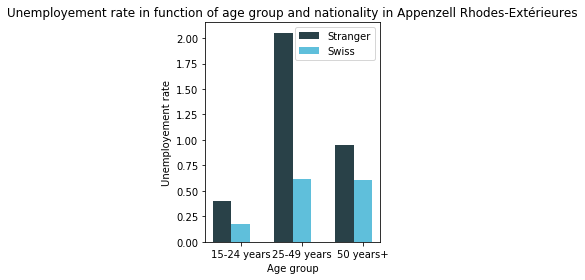

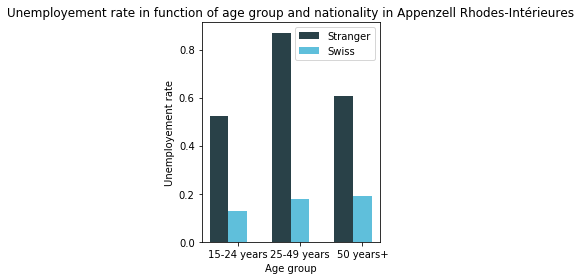

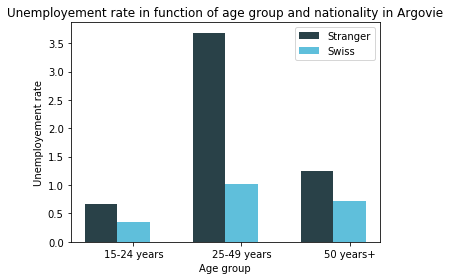

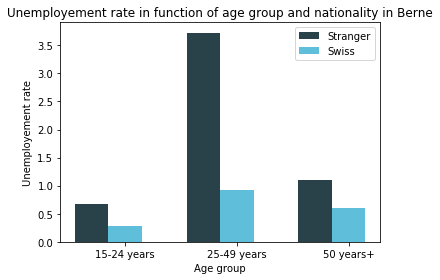

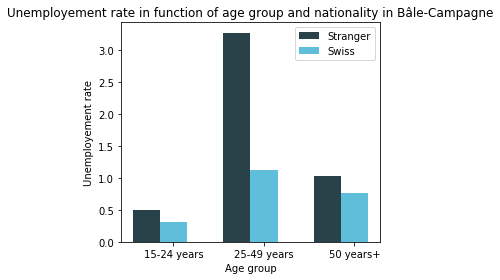

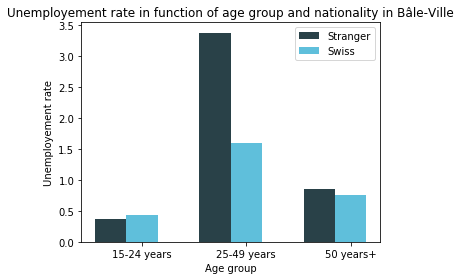

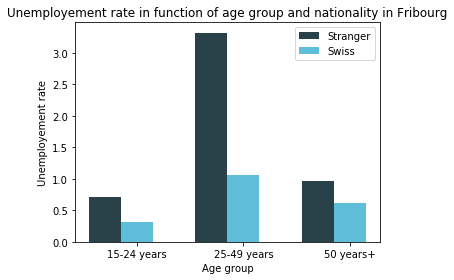

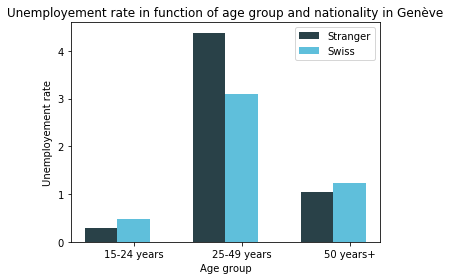

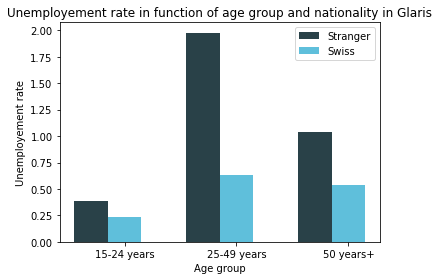

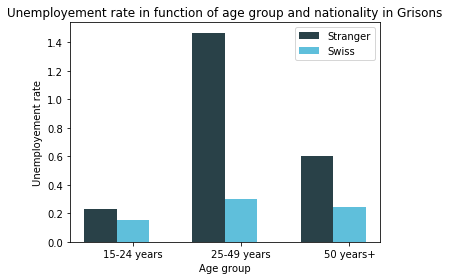

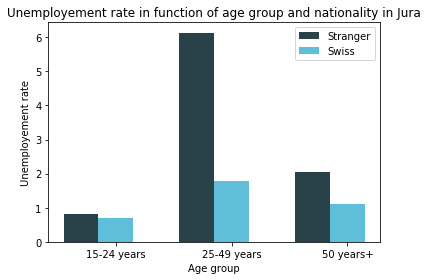

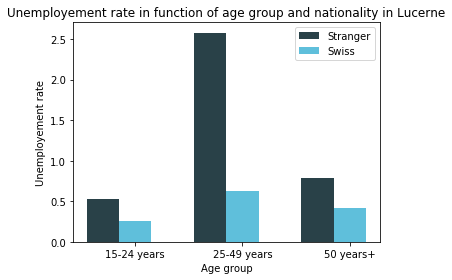

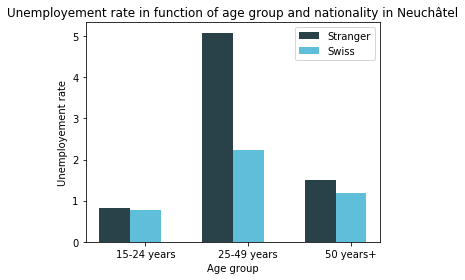

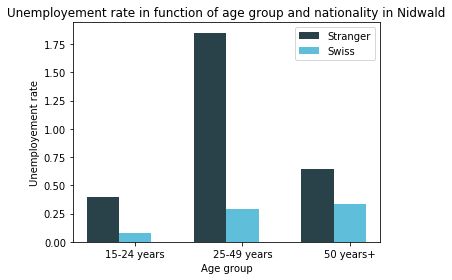

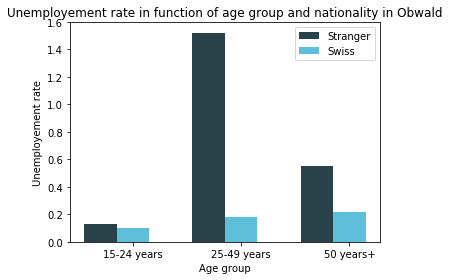

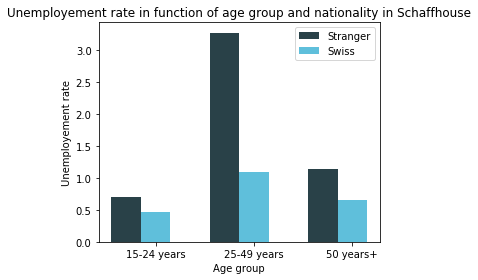

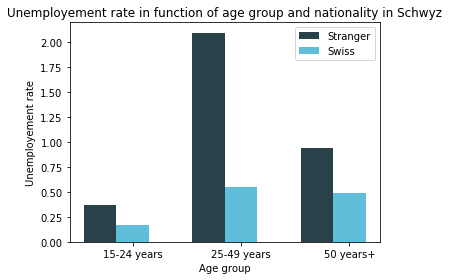

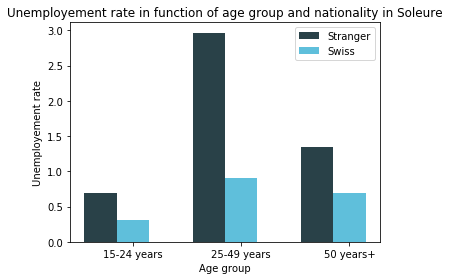

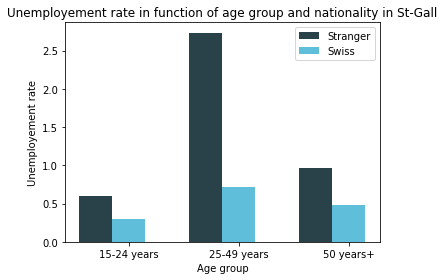

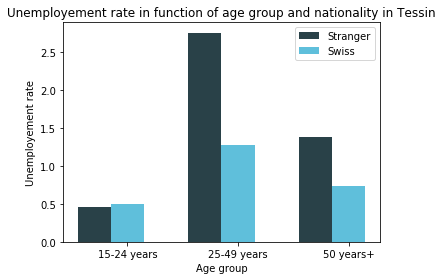

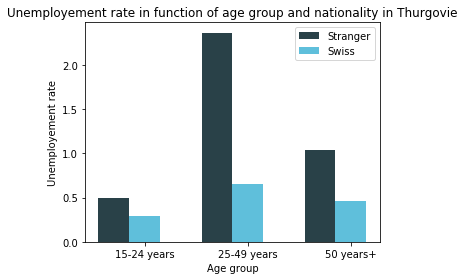

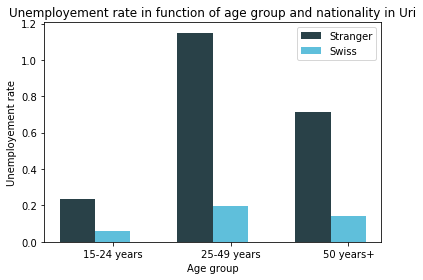

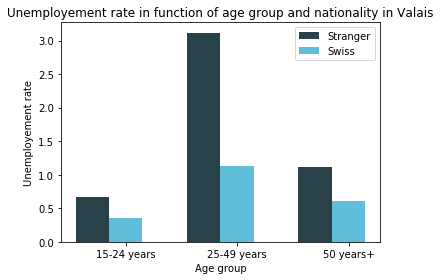

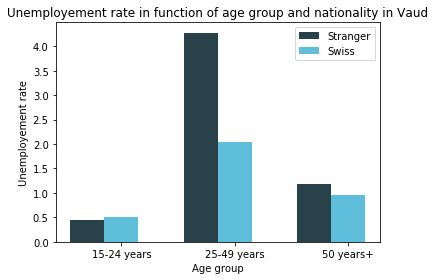

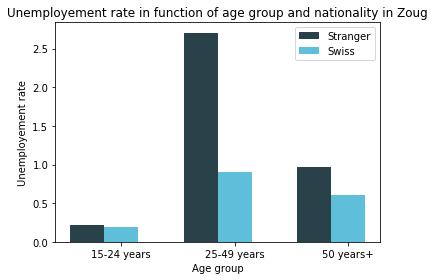

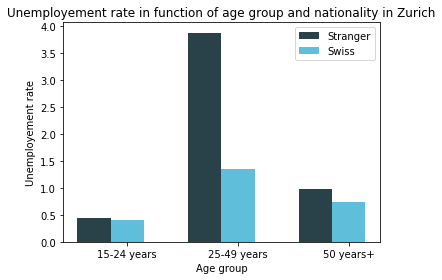

In [34]:
df3 = df2.sort_index(level=['Canton','Nationalité'])

# plot the unemployement rate of the canton in function of age, and nationality
def plotCanton(cantonName):
    n_groups = 3
    data = df3.loc[[cantonName],['Unemployement percentage']].values
    data = data.flatten()
    dataStranger = data[0:3]
    dataSwiss = data[3:6]

    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.9

    rects1 = plt.bar(index, dataStranger, bar_width,
                     alpha=opacity,
                     color='#122C34',
                     label='Stranger')

    rects2 = plt.bar(index + bar_width, dataSwiss, bar_width,
                     alpha=opacity,
                     color='#4EB8D8',
                     label='Swiss')

    plt.xlabel('Age group')
    plt.ylabel('Unemployement rate')
    plt.title('Unemployement rate in function of age group and nationality in {}'.format(cantonName))
    plt.xticks(index + bar_width, ('15-24 years', '25-49 years', '50 years+'))
    plt.legend()

    plt.tight_layout()
    plt.show()
  
# retrieve all the canton name and create a bar plot for each canton
listCanton = df3.index.levels[0].values

for canton in listCanton:
    if(not canton=='Total'):
        plotCanton(canton)

We created bar charts for each canton. Each plot is a different canton, there is 3 class of age, and each class has its own ratio of unemployement of stranger and swiss.

We notice a trend between all the plot, **the biggest ratio** of unemployement is always in the group of strangers with age between 25 and 49 years.

Every time we have a bigger ratio of unemployement concerning strangers, it is true except for Geneva and Vaud.

## Question 4.
*BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

### Using the Maps of question 3
The **Romandy** is composed of Geneva, Jura, Neuchâtel, Vaud and a part of Bern, Fribourg and Valais. It is the french-speaking region of Switzerland. The **German-speaking region** includes the other cantons, at the exception of the Grisons and Ticino.
We can estimate with our map that the **German-speaking region** has a lower unemployement difference between stranger and Swiss than the **Romandy** in all the cantons (except Geneva).

### Using the Maps of the question 2

The maps made in question 2 are more informative on the röstigraben.

From the v2 unemployement rate (the 'official' one - without employed people seeking a new job), there is a clear difference between french and german speaking cantons : all french/italian speaking cantons have rates in [4.3%, 7.2%] while nearly all german speaking cantons lie within [1.4%, 4.3%] - Schaffheausen excepted.

Given that the french/italian part has a quite uniform rate, we could estimate it at roughly 6.5%. Then, for the german speaking part, we can omit the central parts of switzerland (Uri, Obwalden, ...) since they are sparesly populated and are "outliers" with a much lower unemployement rate than the rest of the german-speaking switzerland. I'd roughly estimate the unemployement rate at 4%.  
These would give us a difference of around 2.5% en unemployement rate across the röstigraben.
